In [1]:
from deap import base, creator, tools, algorithms
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import random

import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
import subprocess
import numpy as np

In [2]:
df_citty = pd.read_csv('cittyWInfo.csv')
display(df_citty)

df_citty['status_3_ratio_mean'] = df_citty['status_3_ratio_mean']*df_citty['ratios_length']*17

#sort by status_3_ratio_mean
df_citty = df_citty.sort_values(by='status_3_ratio_mean', ascending=True)
display(df_citty[['Unnamed: 0','longitude', 'latitude', 'status_3_ratio_mean']])
df_citty[['Unnamed: 0','longitude', 'latitude', 'status_3_ratio_mean']].to_csv('citty.csv', index=False)


,Unnamed: 0.1,Unnamed: 0,slug,status_3_ratio_mean,status_3_ratio_var,latitude,longitude,ratios,ratios_length,minCapacity,maxCapacity,NAME_2
0,0,329,x5623z,0.759760,0.182567,55.732861,12.386630,[0.7597597597597597],1,50.0,50.0,Ballerup
1,1,47,5nykwy,0.579191,0.243785,55.858522,9.851593,[0.5791907514450867],1,75.0,75.0,Horsens
2,2,12,2j72qy,0.540725,0.150718,55.614600,12.355200,"[0.5385325334563913, 0.5429164743885556]",2,43.0,50.0,Ishøj
3,3,315,wj3qw6,0.512125,0.064865,55.676120,12.559046,"[0.6290435187340004, 0.533395392134047, 0.6032...",5,11.0,50.0,København
4,4,97,7w9qrp,0.494912,0.140039,56.182788,10.103635,"[0.4364014801110083, 0.553422756706753]",2,22.0,50.0,Århus
...,...,...,...,...,...,...,...,...,...,...,...,...
261,261,267,pz5kg3,0.010855,0.005311,55.130120,9.129680,"[0.008545034642032332, 0.013163972286374134]",2,43.0,50.0,Tønder
262,262,90,7nyr93,0.009227,0.009144,56.781975,8.836123,[0.00922722029988466],1,50.0,50.0,Morsø
263,263,349,y67jq,0.008146,0.002712,56.964766,9.241929,"[0.0349002849002849, 0.002849002849002849, 0.0...",5,11.0,150.0,Vesthimmerland
264,264,46,5np96k,0.007568,0.003728,57.061677,10.182387,"[0.0122537241710716, 0.0028832292167227293]",2,90.0,90.0,Aalborg


,Unnamed: 0,longitude,latitude,status_3_ratio_mean
262,90,8.836123,56.781975,0.156863
264,46,10.182387,57.061677,0.257328
261,267,9.129680,55.130120,0.369053
265,31,11.342991,55.414030,0.441866
258,81,9.911765,56.359149,0.491855
...,...,...,...,...
71,246,10.061784,56.430273,70.823307
11,299,12.504799,55.772665,90.901028
33,215,10.426722,55.386511,93.891313
124,73,10.063318,56.429629,94.527160


In [3]:
weights = {
    "traffic_weight": 0,
    "apartments_weight": 0,
    "cinemas_weight": 0,
    "clinics_weight": 0,
    "colleges_weight": 0,
    "communityCentres_weight": 0,
    "conferenceCentres_weight": 0,
    "dentists_weight": 0,
    "eventsVenues_weight": 0,
    "fastFoods_weight": 0,
    "hospitals_weight": 0,
    "hotels_weight": 0,
    "leisureFitnessCentres_weight": 0,
    "leisureStadiums_weight": 0,
    "placesOfWorship_weight": 0,
    "restaurants_weight": 0,
    "shopMalls_weight": 0,
    "shopSupermarkets_weight": 0,
    "sportsCentres_weight": 0,
    "sportsHalls_weight": 0,
    "stadiums_weight": 0,
    "substationMinorDistributions_weight": 0,
    "theatres_weight": 0,
    "universities_weight": 0
}
with open("weights_float.txt", "w") as file:
    for name, value in weights.items():
        file.write(f"{name} {float(value)}\n")

minDistance = {
    'traffic_distance': 0.1,
    'apartments_distance': 0.1,
    'cinemas_distance': 0.1,
    'clinics_distance': 0.1,
    'colleges_distance': 0.1,
    'communityCentres_distance': 0.1,
    'conferenceCentres_distance': 0.1,
    'dentists_distance': 0.1,
    'eventsVenues_distance': 0.1,
    'fastFoods_distance': 0.1,
    'hospitals_distance': 0.1,
    'hotels_distance': 0.1,
    'leisureFitnessCentres_distance': 0.1,
    'leisureStadiums_distance': 0.1,
    'placesOfWorship_distance': 0.1,
    'restaurants_distance': 0.1,
    'shopMalls_distance': 0.1,
    'shopSupermarkets_distance': 0.1,
    'sportsCentres_distance': 0.1,
    'sportsHalls_distance': 0.1,
    'stadiums_distance': 0.1,
    'substationMinorDistributions_distance': 0.1,
    'theatres_distance': 0.1,
    'universities_distance': 0.1
}


with open("minDistance.txt", "w") as file:
    for name, value in minDistance.items():
        file.write(f"{name} {float(value)}\n")

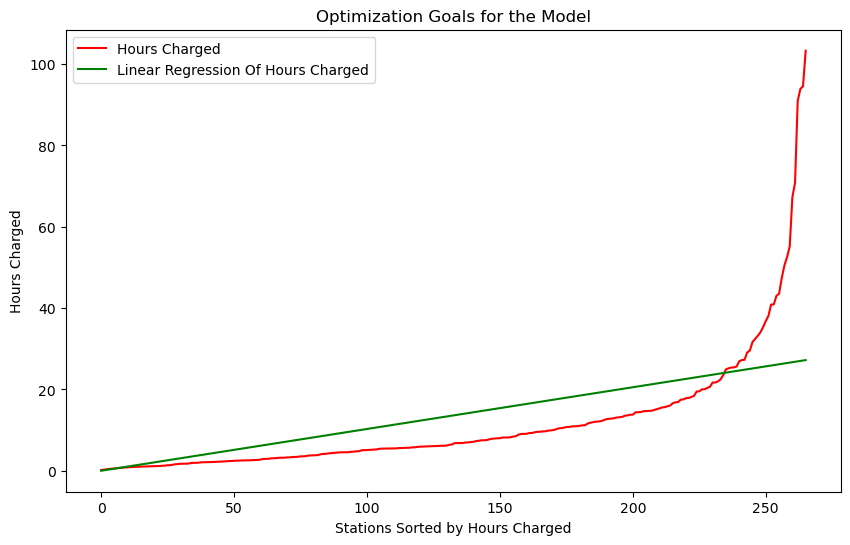

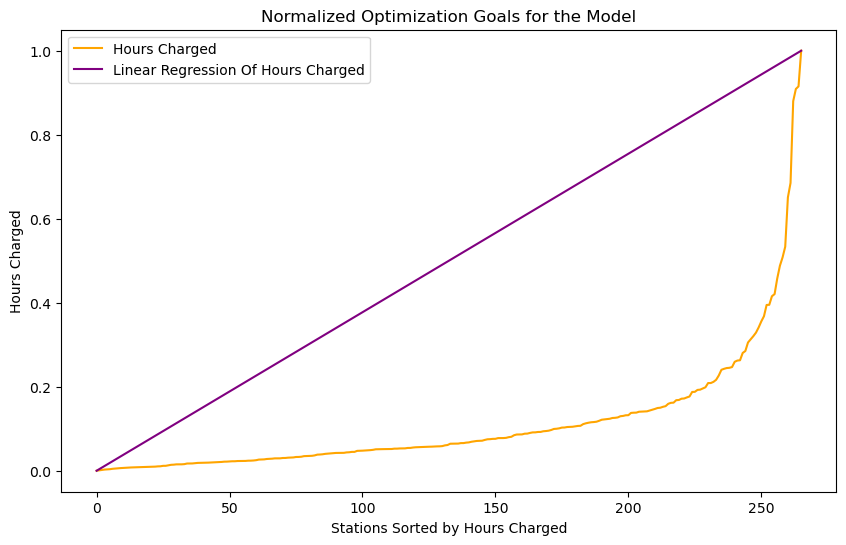

In [4]:
X = np.arange(len(df_citty)).reshape(-1, 1)  # Element numbers as X
y_original = df_citty['status_3_ratio_mean'].values.reshape(-1, 1)  # status_3_ratio_mean as Y, reshaped for scaler

# Normalize X and y
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y_original)

# Fit the model
model = LinearRegression(fit_intercept=False)
model.fit(X, y_original)

# Predict using the scaled features
y_lin = model.predict(X)
y_scaled_lin = scaler_y.fit_transform(y_lin)

# Plotting the results (optional)
plt.figure(figsize=(10, 6))
plt.plot(X, y_original, color='red', label='Hours Charged')
plt.plot(X, y_lin, color='green', label='Linear Regression Of Hours Charged')

plt.title('Optimization Goals for the Model')
plt.xlabel('Stations Sorted by Hours Charged')
plt.ylabel('Hours Charged')
plt.legend()
plt.show()

# Plotting the results (optional)
plt.figure(figsize=(10, 6))
plt.plot(X, y_scaled, color='orange', label='Hours Charged')
plt.plot(X, y_scaled_lin, color='purple', label='Linear Regression Of Hours Charged')

plt.title('Normalized Optimization Goals for the Model')
plt.xlabel('Stations Sorted by Hours Charged')
plt.ylabel('Hours Charged')
plt.legend()
plt.show()

In [5]:
def custom_cxBlend(ind1, ind2, alpha):
    for i in range(len(ind1)):
        gamma = (1. + 2. * alpha) * random.random() - alpha
        ind1[i], ind2[i] = ind1[i] + gamma * (ind2[i] - ind1[i]), ind2[i] + gamma * (ind1[i] - ind2[i])
        ind1[i], ind2[i] = max(0, ind1[i]), max(0, ind2[i])  # Ensure non-negative
    return ind1, ind2

def custom_mutGaussian(individual, mu, sigma, indpb):
    size = len(individual)
    for i in range(size):
        if random.random() < indpb:
            individual[i] += random.gauss(mu, sigma)
            individual[i] = max(0, individual[i])  # Ensure non-negative
    return individual,


gen	nevals	avg    	min    	var      	std     
0  	50    	17.9186	17.2546	0.0664478	0.257775
1  	40    	17.6575	16.176 	0.0962577	0.310254
2  	32    	17.469 	15.9151	0.866655 	0.930943
3  	40    	16.9527	15.9151	0.399274 	0.631881
4  	34    	16.9998	15.4746	10.7543  	3.27937 
5  	46    	16.0927	15.38  	0.359404 	0.599503
6  	33    	16.1526	15.1901	5.14024  	2.26721 
7  	41    	15.6555	15.1331	0.196592 	0.443387
8  	41    	15.496 	14.932 	0.114646 	0.338594
9  	38    	15.3588	14.9271	0.133787 	0.365769
10 	35    	15.141 	14.8355	0.0461064	0.214724
11 	39    	15.3313	14.8355	3.04843  	1.74598 
12 	35    	15.2374	14.8082	1.32585  	1.15146 
13 	31    	15.199 	14.782 	0.913096 	0.955561
14 	41    	15.5084	14.782 	7.50342  	2.73924 
15 	39    	15.2944	14.788 	1.87523  	1.36939 
16 	42    	15.2168	14.7863	2.63853  	1.62436 
17 	40    	14.9091	14.7747	0.121246 	0.348204
18 	36    	14.8981	14.7747	0.182621 	0.427342
19 	34    	14.9802	14.7604	0.538256 	0.733659
20 	33    	15.1095	14.7577	1.27816

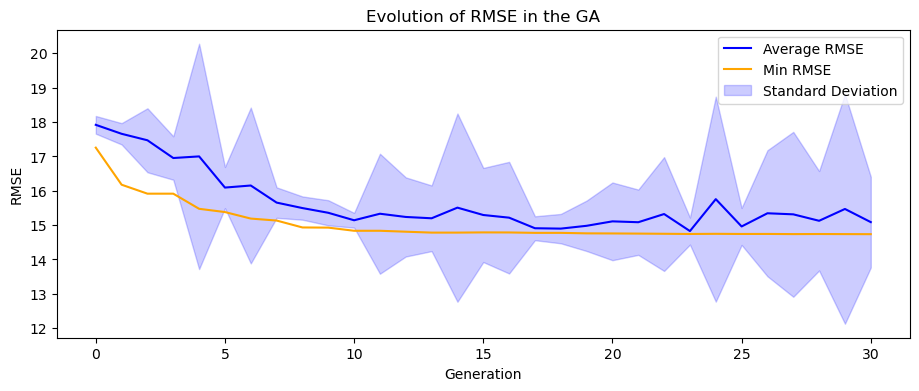

[[0.006036796260870922,
  0.006845229173287555,
  0,
  9.623669830318515e-05,
  0.007864043785238728,
  0.0005889214325026515,
  0.016039310271382626,
  0.000988843826030646,
  1.2776833728047742e-05,
  0.08006420457317243,
  3.970599415813592e-06,
  0.010843974074899508,
  0.005679075367368713,
  0.000894696806358566,
  0.005518607594906824,
  0.04745147320872496,
  0.0875251378315887,
  0.019413877109354345,
  0.004779747577369463,
  0,
  0.0019046592791548272,
  0.049237338830680294,
  0.0002220511885179335,
  0.2281388025475049]]

Best MSE: 14.736544297248502
Best Weights:
traffic_weight: 0.006036796260870922
apartments_weight: 0.006845229173287555
cinemas_weight: 0
clinics_weight: 9.623669830318515e-05
colleges_weight: 0.007864043785238728
communityCentres_weight: 0.0005889214325026515
conferenceCentres_weight: 0.016039310271382626
dentists_weight: 0.000988843826030646
eventsVenues_weight: 1.2776833728047742e-05
fastFoods_weight: 0.08006420457317243
hospitals_weight: 3.970599415813592e-06
hotels_weight: 0.010843974074899508
leisureFitnessCentres_weight: 0.005679075367368713
leisureStadiums_weight: 0.000894696806358566
placesOfWorship_weight: 0.005518607594906824
restaurants_weight: 0.04745147320872496
shopMalls_weight: 0.0875251378315887
shopSupermarkets_weight: 0.019413877109354345
sportsCentres_weight: 0.004779747577369463
sportsHalls_weight: 0
stadiums_weight: 0.0019046592791548272
substationMinorDistributions_weight: 0.049237338830680294
theatres_weight: 0.0002220511885179335
universities_weight: 0.22813880

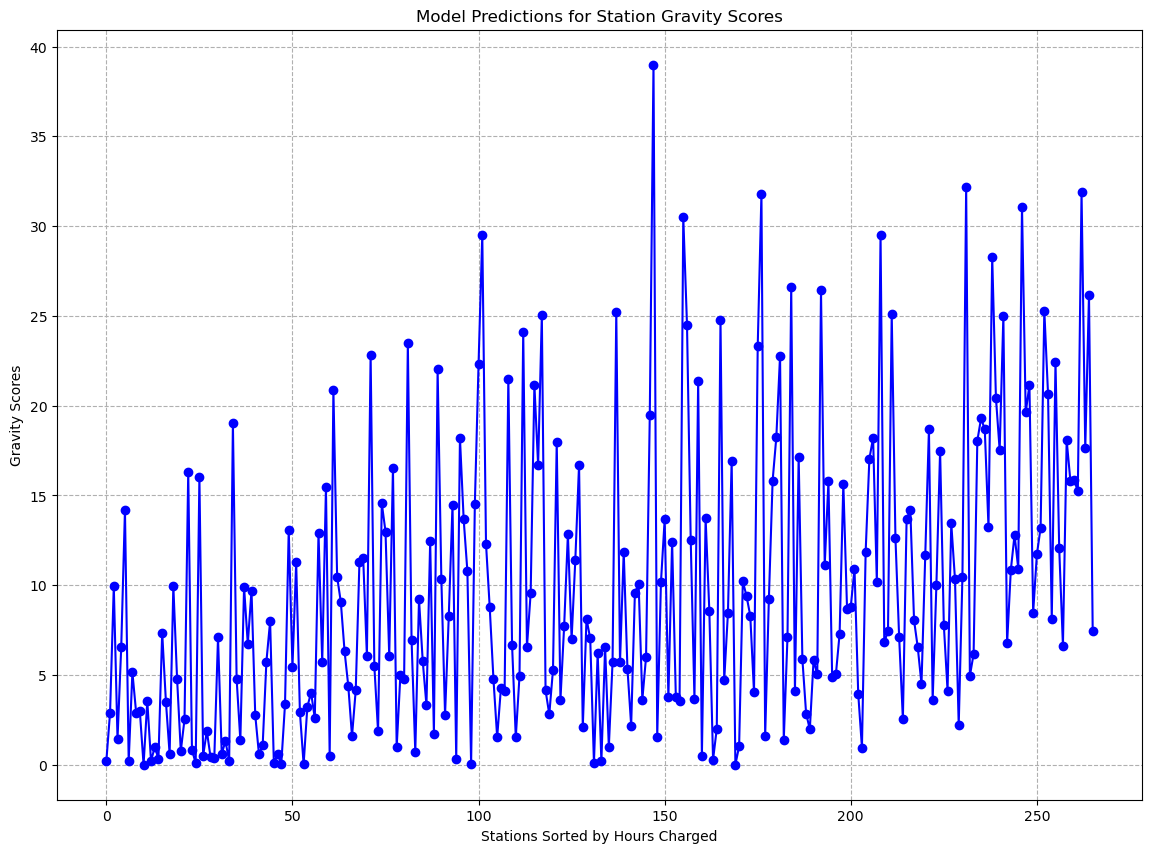

Mean Squared Error (MSE): 217.16573782476732
Root Mean Squared Error (RMSE): 14.736544297248502
NRMSE: 0.1428959965667918


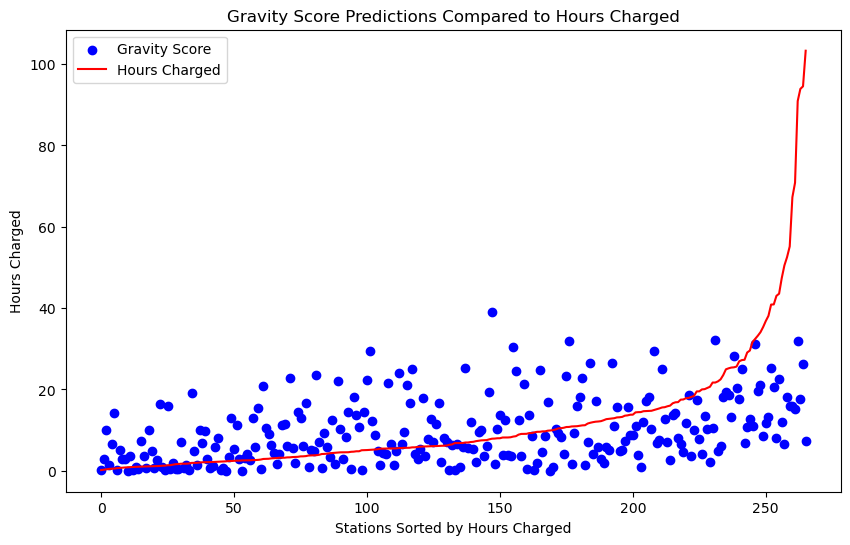

Mean Squared Error (MSE): 90.22365707151805
Root Mean Squared Error (RMSE): 9.498613428891506
NRMSE: 0.34917977726983157


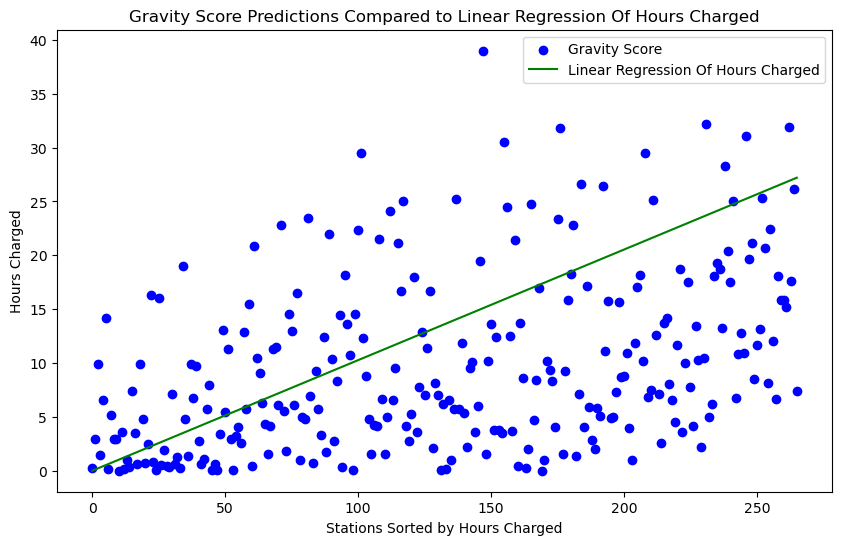

In [6]:
def evaluate(individual):
    # Convert GA individual (set of weights) into your weights' dictionary structure
    new_weights = {name: weight for name, weight in zip(weights.keys(), individual)}

    # Write these new weights into the format your C++ program expects
    with open("weights_float.txt", "w") as file:
        for name, value in new_weights.items():
            file.write(f"{name} {value}\n")

    # Run the C++ program
    try:
        subprocess.run(['./gravityscore', 'citty.csv'], check=True)
        
        # Process the output CSV file
        df_gravity = pd.read_csv('gravityScoresWithDetails.csv')
        df_gravity['gravity'] = df_gravity['gravity'].apply(lambda x: 0 if x < 0 else x)

        mse = mean_squared_error(y_original, df_gravity['gravity'])
        rmse = np.sqrt(mse)
    except subprocess.CalledProcessError as e:
        print(f"Error running C++ program: {e}")
        rmse = float('inf')  # Assign a high MSE value in case of error

    return (rmse,)

# Genetic algorithm setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, 0, 0.01)  # Adjust range as needed
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=len(weights))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", custom_cxBlend, alpha=0.5)
toolbox.register("mutate", custom_mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Parameters for the GA
population_size = 50
crossover_probability = 0.7
mutation_probability = 0.2
number_of_generations = 30

stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("var", np.var)
stats.register("std", np.std)


population = toolbox.population(n=population_size)
hof = tools.HallOfFame(1)  # To keep track of the best individual ever found

final_population, logbook = algorithms.eaSimple(population, toolbox, cxpb=crossover_probability, mutpb=mutation_probability, ngen=number_of_generations, stats=stats, halloffame=hof, verbose=True)

# Assuming logbook is already defined and populated
gen = np.array(logbook.select("gen"))
avg_mse = np.array(logbook.select("avg"))
min_mse = np.array(logbook.select("min"))
std_mse = np.array(logbook.select("std"))

# Calculate the upper and lower bounds for the shaded area
upper_bound = avg_mse + std_mse
lower_bound = avg_mse - std_mse

# Plot the graph
plt.figure(figsize=(11, 4))
plt.title("Evolution of RMSE in the GA")
plt.plot(gen, avg_mse, label="Average RMSE", color="blue")
plt.plot(gen, min_mse, label="Min RMSE", color="orange")
plt.fill_between(gen, lower_bound, upper_bound, color='blue', alpha=0.2, label="Standard Deviation")
plt.xlabel("Generation")
plt.ylabel("RMSE")
plt.legend()
plt.show()
display(hof.items)
# Assuming 'hof' is your HallOfFame object
best_individual = hof[0]  # The best individual
best_weights = {name: weight for name, weight in zip(weights.keys(), best_individual)}
best_mse = best_individual.fitness.values[0]

print("Best MSE:", best_mse)
print("Best Weights:")
for name, weight in best_weights.items():
    print(f"{name}: {weight}")
with open("weights_float.txt", "w") as file:
    for name, value in best_weights.items():
        file.write(f"{name} {float(value)}\n")
# Define the path to the compiled executable
executable_path = './gravityscore'

# The CSV file name to pass as an argument
csv_file_name = 'citty.csv'

# Run the compiled C++ program with the CSV file name as an argument
result = subprocess.run([executable_path, csv_file_name], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

# Process the result
if result.returncode == 0:
    print("C++ program output:\n", result.stdout)
else:
    print("Error running C++ program:\n", result.stderr)
df_gravity = pd.read_csv('gravityScoresWithDetails.csv')
#change all gravity that a negative to zero
df_gravity['gravity'] = df_gravity['gravity'].apply(lambda x: 0 if x < 0 else x)

#plot df_gravity where x asis the the index and y axis the gravity
plt.figure(figsize=(14, 10))
plt.plot(df_gravity.index, df_gravity['gravity'], marker='o', linestyle='-', color='blue')
plt.xlabel('Stations Sorted by Hours Charged')
plt.ylabel('Gravity Scores')
plt.title('Model Predictions for Station Gravity Scores')
plt.grid(True, which="both", ls="--")
plt.show()
def nrmse(y_true, rmse_value):
    """Calculate the Normalized Root Mean Square Error."""
    range_value = np.max(y_true) - np.min(y_true)
    return rmse_value / range_value

X = np.arange(len(df_citty)).reshape(-1, 1)  # Element numbers as X
y = df_gravity['gravity'].values.reshape(-1, 1)
#y = df_reordered_sorted['status_3_ratio_mean'].values.reshape(-1, 1)  # status_3_ratio_mean as Y, reshaped for scaler


scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_gravity_scaled = scaler_y.fit_transform(y)


# Calculate MSE on the scaled predictions
mse = mean_squared_error(y, y_original)
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
nrmse_value = nrmse(y_original, rmse)
print(f"NRMSE: {nrmse_value}")

# Plotting the results (optional)
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Gravity Score')
plt.plot(X, y_original, color='red', label='Hours Charged')
plt.title('Gravity Score Predictions Compared to Hours Charged')
plt.xlabel('Stations Sorted by Hours Charged')
plt.ylabel('Hours Charged')
plt.legend()
plt.show()


# Calculate MSE on the scaled predictions
mse = mean_squared_error(y, y_lin)
rmse = np.sqrt(mse)
nrmse_value = nrmse(y_lin, rmse)


print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"NRMSE: {nrmse_value}")


# Plotting the results (optional)
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Gravity Score')
plt.plot(X, y_lin, color='green', label='Linear Regression Of Hours Charged')
plt.title('Gravity Score Predictions Compared to Linear Regression Of Hours Charged')
plt.xlabel('Stations Sorted by Hours Charged')
plt.ylabel('Hours Charged')
plt.legend()
plt.show()


In [7]:
def evaluate(individual):
    # Convert GA individual (set of weights) into your weights' dictionary structure
    new_weights = {name: weight for name, weight in zip(weights.keys(), individual)}

    # Write these new weights into the format your C++ program expects
    with open("weights_float.txt", "w") as file:
        for name, value in new_weights.items():
            file.write(f"{name} {value}\n")

    # Run the C++ program
    try:
        subprocess.run(['./gravityscore', 'citty.csv'], check=True)
        
        # Process the output CSV file
        df_gravity = pd.read_csv('gravityScoresWithDetails.csv')
        df_gravity['gravity'] = df_gravity['gravity'].apply(lambda x: 0 if x < 0 else x)

        mse = mean_squared_error(y_lin, df_gravity['gravity'])
        rmse = np.sqrt(mse)
    except subprocess.CalledProcessError as e:
        print(f"Error running C++ program: {e}")
        rmse = float('inf')  # Assign a high MSE value in case of error

    return (rmse,)

# Genetic algorithm setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, 0, 0.01)  # Adjust range as needed
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=len(weights))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", custom_cxBlend, alpha=0.5)
toolbox.register("mutate", custom_mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Parameters for the GA
population_size = 50
crossover_probability = 0.7
mutation_probability = 0.2
number_of_generations = 30

stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("var", np.var)
stats.register("std", np.std)


population = toolbox.population(n=population_size)
hof = tools.HallOfFame(1)  # To keep track of the best individual ever found

final_population, logbook = algorithms.eaSimple(population, toolbox, cxpb=crossover_probability, mutpb=mutation_probability, ngen=number_of_generations, stats=stats, halloffame=hof, verbose=True)


c:\Users\basti\anaconda3\envs\RnDenv\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\basti\anaconda3\envs\RnDenv\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg    	min   	var     	std     
0  	50    	13.7679	12.973	0.122442	0.349917
1  	41    	13.3588	11.9928	0.194646	0.441188
2  	39    	12.9934	10.8196	0.541618	0.735947
3  	35    	12.3182	10.2391	0.792839	0.890415
4  	32    	11.4363	10.2391	1.44147 	1.20061 
5  	37    	10.8072	9.49447	0.672862	0.820282
6  	42    	10.9516	9.49447	6.43889 	2.5375  
7  	48    	10.2294	9.49422	0.267854	0.517546
8  	35    	10.1249	9.41366	0.478619	0.691823
9  	36    	9.84793	9.38544	0.134402	0.366609
10 	40    	10.0172	9.02249	2.25712 	1.50237 
11 	38    	9.71782	9.03912	0.453158	0.67317 
12 	33    	9.82399	9.03912	3.41339 	1.84754 
13 	40    	10.032 	9.03207	7.90428 	2.81146 
14 	33    	9.56234	8.94324	0.836574	0.914644
15 	42    	9.86794	8.94324	3.67897 	1.91807 
16 	45    	9.22694	8.86721	0.0822043	0.286713
17 	40    	9.5655 	8.86721	3.65272  	1.91121 
18 	34    	9.28163	8.86721	1.62345  	1.27415 
19 	33    	9.81278	8.85083	5.82244  	2.41297 
20 	33    	9.84502	8.85644	10.6497  	3.26339 
21 	37 

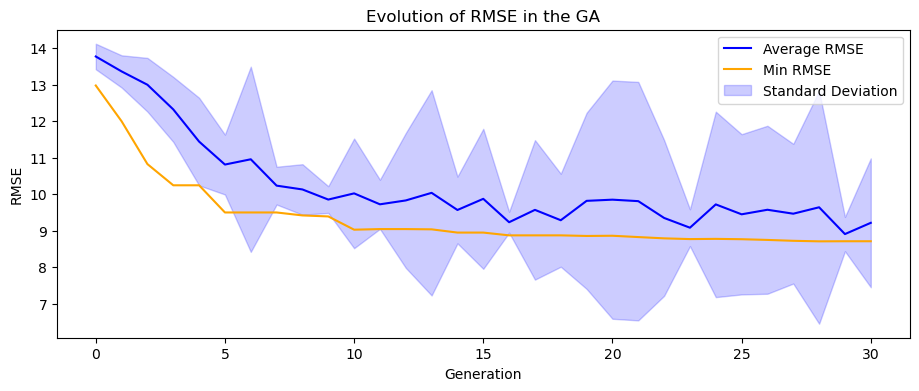

In [8]:
# Assuming logbook is already defined and populated
gen = np.array(logbook.select("gen"))
avg_mse = np.array(logbook.select("avg"))
min_mse = np.array(logbook.select("min"))
std_mse = np.array(logbook.select("std"))

# Calculate the upper and lower bounds for the shaded area
upper_bound = avg_mse + std_mse
lower_bound = avg_mse - std_mse

# Plot the graph
plt.figure(figsize=(11, 4))
plt.title("Evolution of RMSE in the GA")
plt.plot(gen, avg_mse, label="Average RMSE", color="blue")
plt.plot(gen, min_mse, label="Min RMSE", color="orange")
plt.fill_between(gen, lower_bound, upper_bound, color='blue', alpha=0.2, label="Standard Deviation")
plt.xlabel("Generation")
plt.ylabel("RMSE")
plt.legend()
plt.show()

In [9]:
display(hof.items)
# Assuming 'hof' is your HallOfFame object
best_individual = hof[0]  # The best individual
best_weights = {name: weight for name, weight in zip(weights.keys(), best_individual)}
best_mse = best_individual.fitness.values[0]

print("Best MSE:", best_mse)
print("Best Weights:")
for name, weight in best_weights.items():
    print(f"{name}: {weight}")

[[0.03174417179121565,
  0.017124517793922562,
  0.0005233022893480054,
  0.024969943227681285,
  0.003096889694170447,
  0.01404598348593055,
  0.0007156641832819458,
  0.00311104685107485,
  0.007224490557606431,
  0.08521205417502428,
  0.0013637254947669246,
  0.001121393910145755,
  0.025195529521023923,
  0.0025564155651137924,
  0.012396101701483168,
  0.025279135681045613,
  0.008739163173817316,
  0.04167925629994757,
  0.0015310782998052604,
  0.01396796926222569,
  0.005132066854533253,
  0.0389728090994637,
  0,
  0.2050588091733639]]

Best MSE: 8.703191023984198
Best Weights:
traffic_weight: 0.03174417179121565
apartments_weight: 0.017124517793922562
cinemas_weight: 0.0005233022893480054
clinics_weight: 0.024969943227681285
colleges_weight: 0.003096889694170447
communityCentres_weight: 0.01404598348593055
conferenceCentres_weight: 0.0007156641832819458
dentists_weight: 0.00311104685107485
eventsVenues_weight: 0.007224490557606431
fastFoods_weight: 0.08521205417502428
hospitals_weight: 0.0013637254947669246
hotels_weight: 0.001121393910145755
leisureFitnessCentres_weight: 0.025195529521023923
leisureStadiums_weight: 0.0025564155651137924
placesOfWorship_weight: 0.012396101701483168
restaurants_weight: 0.025279135681045613
shopMalls_weight: 0.008739163173817316
shopSupermarkets_weight: 0.04167925629994757
sportsCentres_weight: 0.0015310782998052604
sportsHalls_weight: 0.01396796926222569
stadiums_weight: 0.005132066854533253
substationMinorDistributions_weight: 0.0389728090994637
theatres_weight: 0
universities_weight

In [10]:
with open("weights_float.txt", "w") as file:
    for name, value in best_weights.items():
        file.write(f"{name} {float(value)}\n")

In [11]:
# Define the path to the compiled executable
executable_path = './gravityscore'

# The CSV file name to pass as an argument
csv_file_name = 'citty.csv'

# Run the compiled C++ program with the CSV file name as an argument
result = subprocess.run([executable_path, csv_file_name], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

# Process the result
if result.returncode == 0:
    print("C++ program output:\n", result.stdout)
else:
    print("Error running C++ program:\n", result.stderr)

C++ program output:
 Time taken: 4226 milliseconds



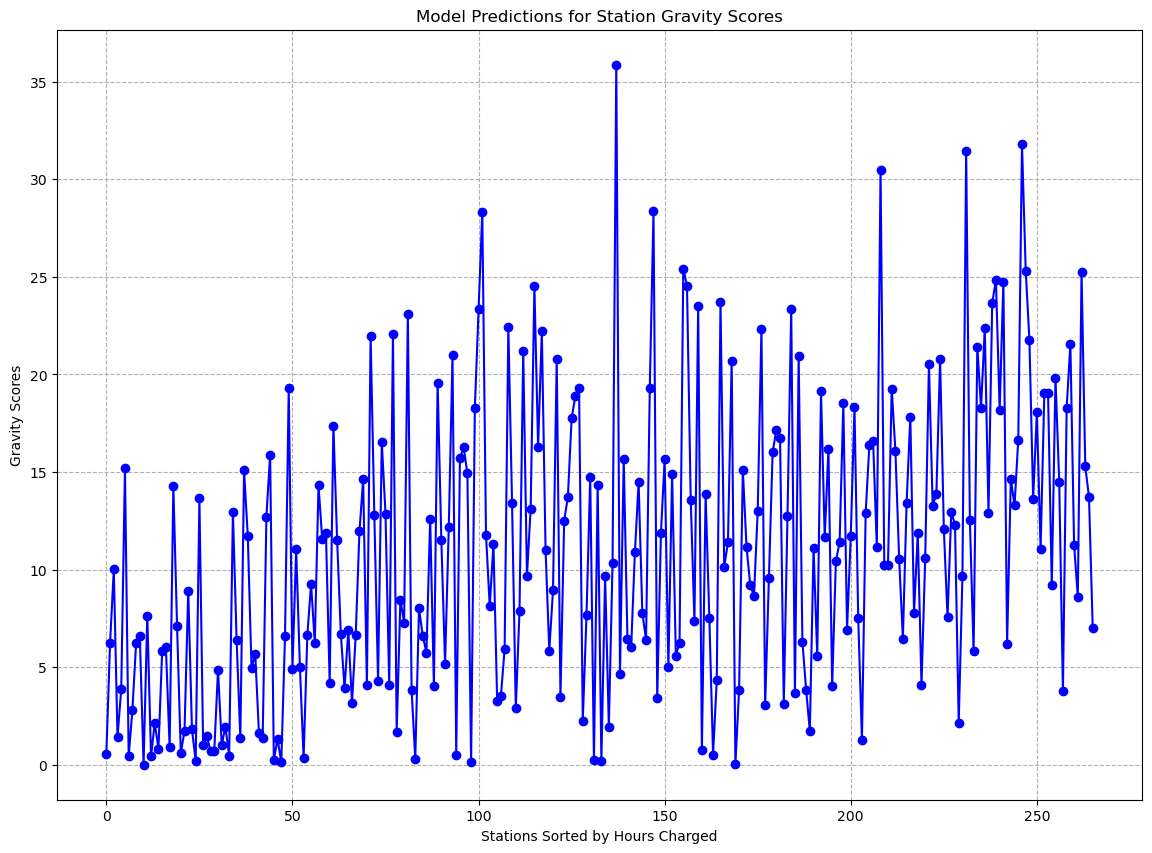

In [12]:
df_gravity = pd.read_csv('gravityScoresWithDetails.csv')
#change all gravity that a negative to zero
df_gravity['gravity'] = df_gravity['gravity'].apply(lambda x: 0 if x < 0 else x)

#plot df_gravity where x asis the the index and y axis the gravity
plt.figure(figsize=(14, 10))
plt.plot(df_gravity.index, df_gravity['gravity'], marker='o', linestyle='-', color='blue')
plt.xlabel('Stations Sorted by Hours Charged')
plt.ylabel('Gravity Scores')
plt.title('Model Predictions for Station Gravity Scores')
plt.grid(True, which="both", ls="--")
plt.show()

Mean Squared Error (MSE): 227.92480462029127
Root Mean Squared Error (RMSE): 15.097178697368964
NRMSE: 0.14639296376357908


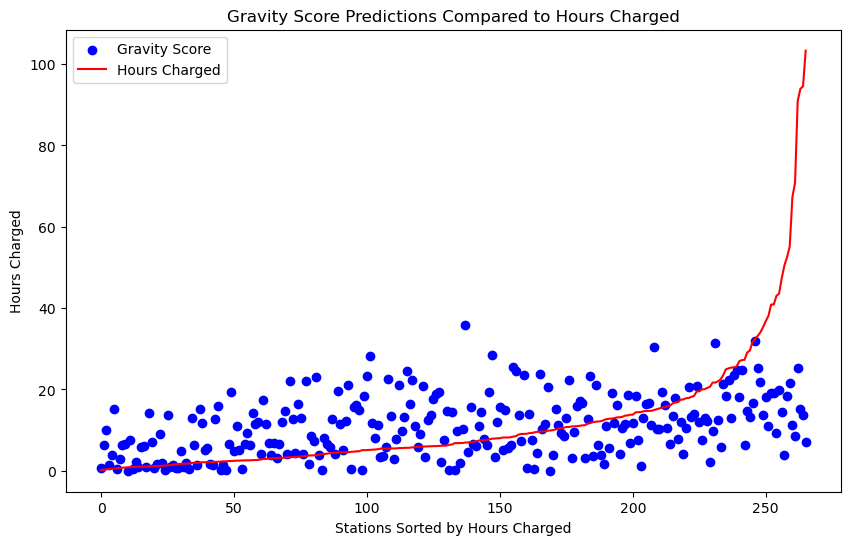

Mean Squared Error (MSE): 75.74553399995912
Root Mean Squared Error (RMSE): 8.703191023984198
NRMSE: 0.3199391496497874


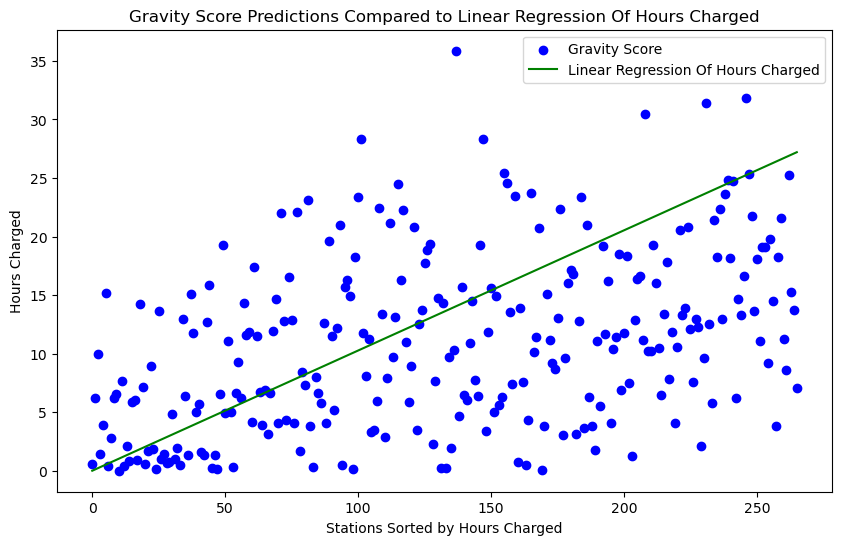

In [13]:
def nrmse(y_true, rmse_value):
    """Calculate the Normalized Root Mean Square Error."""
    range_value = np.max(y_true) - np.min(y_true)
    return rmse_value / range_value

X = np.arange(len(df_citty)).reshape(-1, 1)  # Element numbers as X
y = df_gravity['gravity'].values.reshape(-1, 1)
#y = df_reordered_sorted['status_3_ratio_mean'].values.reshape(-1, 1)  # status_3_ratio_mean as Y, reshaped for scaler


scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_gravity_scaled = scaler_y.fit_transform(y)


# Calculate MSE on the scaled predictions
mse = mean_squared_error(y, y_original)
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
nrmse_value = nrmse(y_original, rmse)
print(f"NRMSE: {nrmse_value}")

# Plotting the results (optional)
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Gravity Score')
plt.plot(X, y_original, color='red', label='Hours Charged')
plt.title('Gravity Score Predictions Compared to Hours Charged')
plt.xlabel('Stations Sorted by Hours Charged')
plt.ylabel('Hours Charged')
plt.legend()
plt.show()


# Calculate MSE on the scaled predictions
mse = mean_squared_error(y, y_lin)
rmse = np.sqrt(mse)
nrmse_value = nrmse(y_lin, rmse)


print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"NRMSE: {nrmse_value}")


# Plotting the results (optional)
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Gravity Score')
plt.plot(X, y_lin, color='green', label='Linear Regression Of Hours Charged')
plt.title('Gravity Score Predictions Compared to Linear Regression Of Hours Charged')
plt.xlabel('Stations Sorted by Hours Charged')
plt.ylabel('Hours Charged')
plt.legend()
plt.show()


c:\Users\basti\anaconda3\envs\RnDenv\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\basti\anaconda3\envs\RnDenv\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg     	min     	var        	std      
0  	50    	0.245359	0.201973	0.000490841	0.0221549
1  	34    	0.23195 	0.19886 	0.00050299 	0.0224274
2  	35    	0.215833	0.19197 	0.000188243	0.0137202
3  	38    	0.209833	0.185898	0.000261193	0.0161615
4  	43    	0.200507	0.181622	0.000103199	0.0101587
5  	44    	0.193337	0.177109	0.000123513	0.0111137
6  	35    	0.189095	0.177036	0.000119501	0.0109316
7  	36    	0.184554	0.173809	8.94119e-05	0.00945579
8  	37    	0.183392	0.173809	6.6615e-05 	0.0081618 
9  	37    	0.180768	0.170802	7.22011e-05	0.00849712
10 	42    	0.178803	0.168581	8.48019e-05	0.0092088 
11 	45    	0.178286	0.168581	0.00014056 	0.0118558 
12 	37    	0.172736	0.167315	2.25274e-05	0.00474631
13 	33    	0.170449	0.166226	7.24625e-06	0.00269189
14 	41    	0.169688	0.166226	1.8974e-05 	0.00435591
15 	37    	0.16976 	0.165656	8.11019e-05	0.00900566
16 	37    	0.169037	0.165046	4.04421e-05	0.00635941
17 	36    	0.169519	0.165046	8.75762e-05	0.00935822
18 	41    	0.168526	

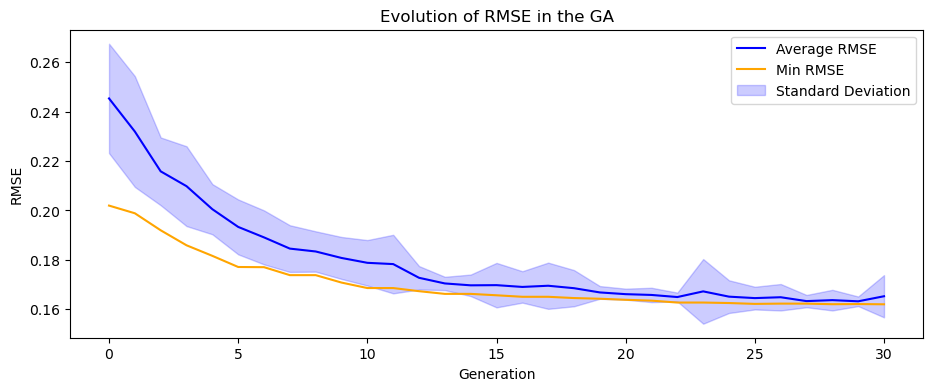

[[3.463665716693061,
  1.0591915088998487,
  229.78226928398698,
  2.9157850005230452,
  34.93043440639274,
  4.994179483826747,
  16.56454301152754,
  15.953933381411346,
  0.4862897999993877,
  85.414393828213,
  18.806057113969494,
  203.08826294324314,
  24.606027719069893,
  0,
  0.08580096461628473,
  41.19799081179135,
  70.02689446514572,
  28.194301624651615,
  19.90670249447506,
  84.41830605230204,
  0,
  60.90791125689414,
  8.861016471665856,
  198.95276784441185]]

Best MSE: 0.16200732099779666
Best Weights:
traffic_weight: 3.463665716693061
apartments_weight: 1.0591915088998487
cinemas_weight: 229.78226928398698
clinics_weight: 2.9157850005230452
colleges_weight: 34.93043440639274
communityCentres_weight: 4.994179483826747
conferenceCentres_weight: 16.56454301152754
dentists_weight: 15.953933381411346
eventsVenues_weight: 0.4862897999993877
fastFoods_weight: 85.414393828213
hospitals_weight: 18.806057113969494
hotels_weight: 203.08826294324314
leisureFitnessCentres_weight: 24.606027719069893
leisureStadiums_weight: 0
placesOfWorship_weight: 0.08580096461628473
restaurants_weight: 41.19799081179135
shopMalls_weight: 70.02689446514572
shopSupermarkets_weight: 28.194301624651615
sportsCentres_weight: 19.90670249447506
sportsHalls_weight: 84.41830605230204
stadiums_weight: 0
substationMinorDistributions_weight: 60.90791125689414
theatres_weight: 8.861016471665856
universities_weight: 198.95276784441185
C++ program output:
 Time taken: 3031 milliseco

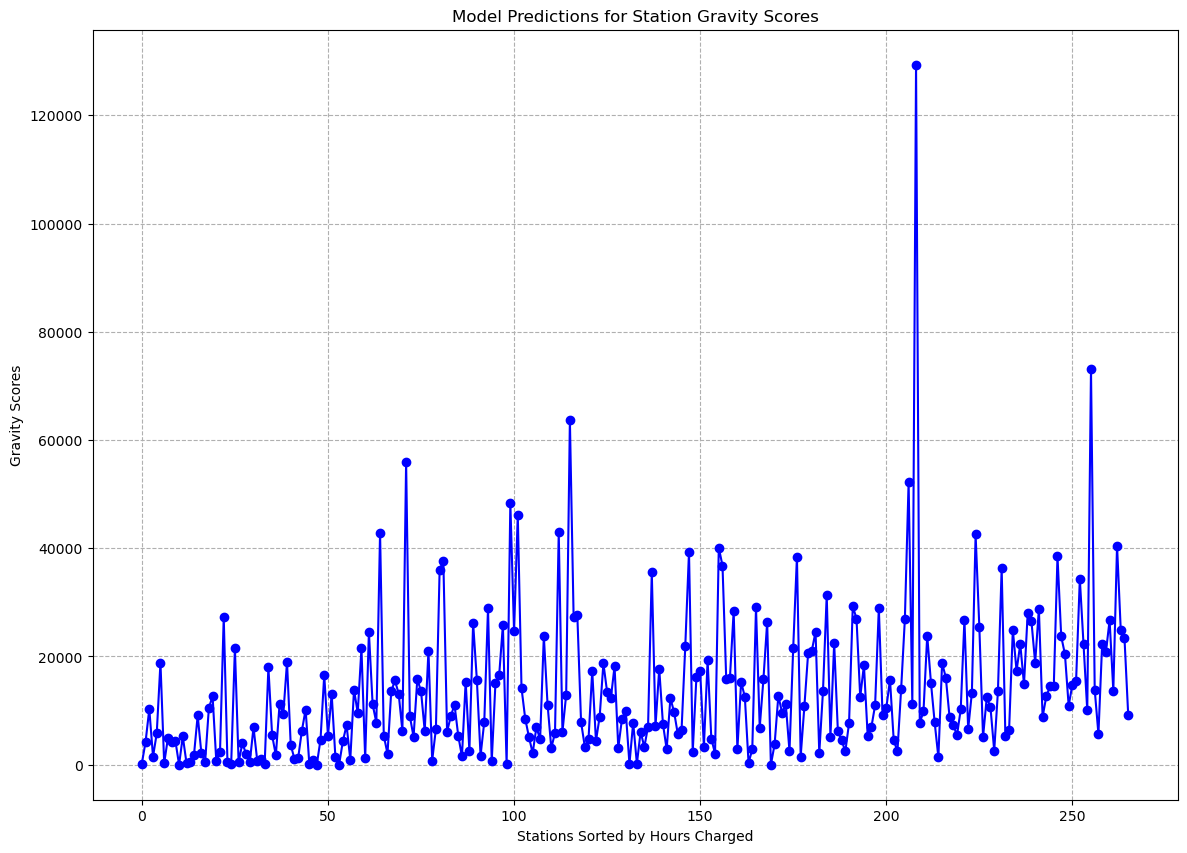

Mean Squared Error (MSE) on scaled data: 0.026246372056883127
Root Mean Squared Error (RMSE) on scaled data: 0.16200732099779666


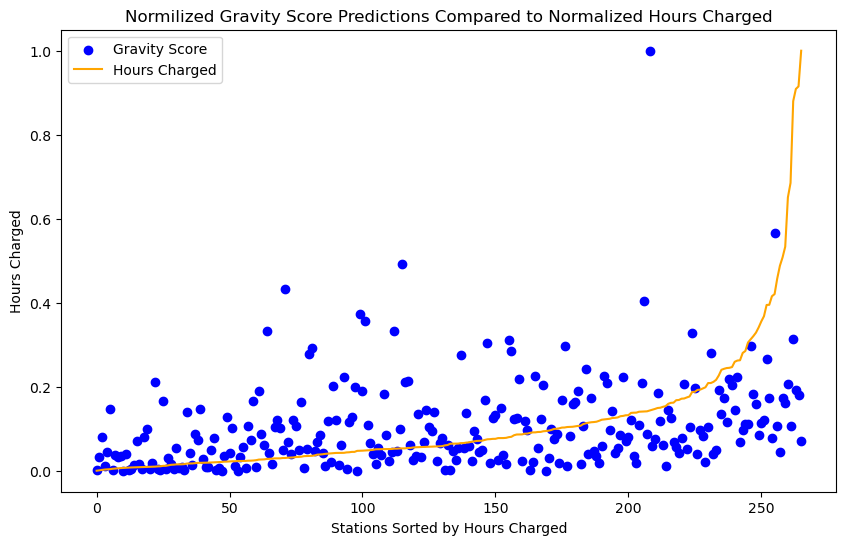

Mean Squared Error (MSE) on scaled data: 0.23181340723485894
Root Mean Squared Error (RMSE) on scaled data: 0.48147004811811395


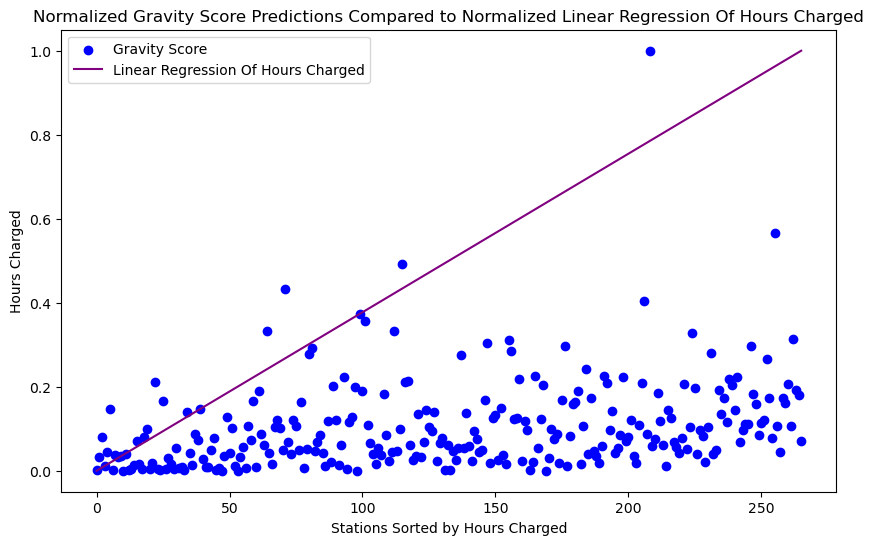

In [14]:
def evaluate(individual):
    # Convert GA individual (set of weights) into your weights' dictionary structure
    new_weights = {name: weight for name, weight in zip(weights.keys(), individual)}

    # Write these new weights into the format your C++ program expects
    with open("weights_float.txt", "w") as file:
        for name, value in new_weights.items():
            file.write(f"{name} {value}\n")

    # Run the C++ program
    try:
        subprocess.run(['./gravityscore', 'citty.csv'], check=True)
        
        # Process the output CSV file
        df_gravity = pd.read_csv('gravityScoresWithDetails.csv')
        df_gravity['gravity'] = df_gravity['gravity'].apply(lambda x: 0 if x < 0 else x)

        # Assuming df_gravity['gravity'] needs to be scaled between 0 and 1 to compare with y_true
        # If df_gravity['gravity'] is already scaled, this step can be adjusted or removed
        scaler = MinMaxScaler()
        y_pred_scaled = scaler.fit_transform(df_gravity[['gravity']]).flatten()
     

        mse = mean_squared_error(y_scaled, y_pred_scaled)
        rmse = np.sqrt(mse)
    except subprocess.CalledProcessError as e:
        print(f"Error running C++ program: {e}")
        rmse = float('inf')  # Assign a high MSE value in case of error

    return (rmse,)

# Genetic algorithm setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, 0, 100)  # Adjust range as needed
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=len(weights))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", custom_cxBlend, alpha=0.5)
toolbox.register("mutate", custom_mutGaussian, mu=0, sigma=100, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Parameters for the GA
population_size = 50
crossover_probability = 0.7
mutation_probability = 0.2
number_of_generations = 30

stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("var", np.var)
stats.register("std", np.std)


population = toolbox.population(n=population_size)
hof = tools.HallOfFame(1)  # To keep track of the best individual ever found

final_population, logbook = algorithms.eaSimple(population, toolbox, cxpb=crossover_probability, mutpb=mutation_probability, ngen=number_of_generations, stats=stats, halloffame=hof, verbose=True)

# Assuming logbook is already defined and populated
gen = np.array(logbook.select("gen"))
avg_mse = np.array(logbook.select("avg"))
min_mse = np.array(logbook.select("min"))
std_mse = np.array(logbook.select("std"))

# Calculate the upper and lower bounds for the shaded area
upper_bound = avg_mse + std_mse
lower_bound = avg_mse - std_mse

# Plot the graph
plt.figure(figsize=(11, 4))
plt.title("Evolution of RMSE in the GA")
plt.plot(gen, avg_mse, label="Average RMSE", color="blue")
plt.plot(gen, min_mse, label="Min RMSE", color="orange")
plt.fill_between(gen, lower_bound, upper_bound, color='blue', alpha=0.2, label="Standard Deviation")
plt.xlabel("Generation")
plt.ylabel("RMSE")
plt.legend()
plt.show()
display(hof.items)
# Assuming 'hof' is your HallOfFame object
best_individual = hof[0]  # The best individual
best_weights = {name: weight for name, weight in zip(weights.keys(), best_individual)}
best_mse = best_individual.fitness.values[0]

print("Best MSE:", best_mse)
print("Best Weights:")
for name, weight in best_weights.items():
    print(f"{name}: {weight}")
with open("weights_float.txt", "w") as file:
    for name, value in best_weights.items():
        file.write(f"{name} {float(value)}\n")
# Define the path to the compiled executable
executable_path = './gravityscore'

# The CSV file name to pass as an argument
csv_file_name = 'citty.csv'

# Run the compiled C++ program with the CSV file name as an argument
result = subprocess.run([executable_path, csv_file_name], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

# Process the result
if result.returncode == 0:
    print("C++ program output:\n", result.stdout)
else:
    print("Error running C++ program:\n", result.stderr)
df_gravity = pd.read_csv('gravityScoresWithDetails.csv')
#change all gravity that a negative to zero
df_gravity['gravity'] = df_gravity['gravity'].apply(lambda x: 0 if x < 0 else x)

#plot df_gravity where x asis the the index and y axis the gravity
plt.figure(figsize=(14, 10))
plt.plot(df_gravity.index, df_gravity['gravity'], marker='o', linestyle='-', color='blue')
plt.xlabel('Stations Sorted by Hours Charged')
plt.ylabel('Gravity Scores')
plt.title('Model Predictions for Station Gravity Scores')
plt.grid(True, which="both", ls="--")
plt.show()
X = np.arange(len(df_citty)).reshape(-1, 1)  # Element numbers as X
y = df_gravity['gravity'].values.reshape(-1, 1)
#y = df_reordered_sorted['status_3_ratio_mean'].values.reshape(-1, 1)  # status_3_ratio_mean as Y, reshaped for scaler


scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_gravity_scaled = scaler_y.fit_transform(y)


# Calculate MSE on the scaled predictions
mse_scaled = mean_squared_error(y_gravity_scaled, y_scaled)
rmse = np.sqrt(mse_scaled)

mse = mean_squared_error(y, y_original)

print(f"Mean Squared Error (MSE) on scaled data: {mse_scaled}")
print(f"Root Mean Squared Error (RMSE) on scaled data: {rmse}")


# Plotting the results (optional)
plt.figure(figsize=(10, 6))
plt.scatter(X, y_gravity_scaled, color='blue', label='Gravity Score')
plt.plot(X, y_scaled, color='orange', label='Hours Charged')
plt.title('Normilized Gravity Score Predictions Compared to Normalized Hours Charged')
plt.xlabel('Stations Sorted by Hours Charged')
plt.ylabel('Hours Charged')
plt.legend()
plt.show()


# Calculate MSE on the scaled predictions
mse_scaled = mean_squared_error(y_gravity_scaled, y_scaled_lin)
rmse = np.sqrt(mse_scaled)

# If you want to calculate MSE on the original scale
mse = mean_squared_error(y, y_original)

print(f"Mean Squared Error (MSE) on scaled data: {mse_scaled}")
print(f"Root Mean Squared Error (RMSE) on scaled data: {rmse}")

# Plotting the results (optional)
plt.figure(figsize=(10, 6))
plt.scatter(X, y_gravity_scaled, color='blue', label='Gravity Score')
plt.plot(X, y_scaled_lin, color='purple', label='Linear Regression Of Hours Charged')
plt.title('Normalized Gravity Score Predictions Compared to Normalized Linear Regression Of Hours Charged')
plt.xlabel('Stations Sorted by Hours Charged')
plt.ylabel('Hours Charged')
plt.legend()
plt.show()

In [15]:
def evaluate(individual):
    # Convert GA individual (set of weights) into your weights' dictionary structure
    new_weights = {name: weight for name, weight in zip(weights.keys(), individual)}

    # Write these new weights into the format your C++ program expects
    with open("weights_float.txt", "w") as file:
        for name, value in new_weights.items():
            file.write(f"{name} {value}\n")

    # Run the C++ program
    try:
        subprocess.run(['./gravityscore', 'citty.csv'], check=True)
        
        # Process the output CSV file
        df_gravity = pd.read_csv('gravityScoresWithDetails.csv')
        df_gravity['gravity'] = df_gravity['gravity'].apply(lambda x: 0 if x < 0 else x)

        # Assuming df_gravity['gravity'] needs to be scaled between 0 and 1 to compare with y_true
        # If df_gravity['gravity'] is already scaled, this step can be adjusted or removed
        scaler = MinMaxScaler()
        y_pred_scaled = scaler.fit_transform(df_gravity[['gravity']]).flatten()
     

        mse = mean_squared_error(y_scaled_lin, y_pred_scaled)
        rmse = np.sqrt(mse)
    except subprocess.CalledProcessError as e:
        print(f"Error running C++ program: {e}")
        rmse = float('inf')  # Assign a high MSE value in case of error

    return (rmse,)

# Genetic algorithm setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, 0, 100)  # Adjust range as needed
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=len(weights))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", custom_cxBlend, alpha=0.5)
toolbox.register("mutate", custom_mutGaussian, mu=0, sigma=100, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Parameters for the GA
population_size = 50
crossover_probability = 0.7
mutation_probability = 0.2
number_of_generations = 30

stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("var", np.var)
stats.register("std", np.std)


population = toolbox.population(n=population_size)
hof = tools.HallOfFame(1)  # To keep track of the best individual ever found

final_population, logbook = algorithms.eaSimple(population, toolbox, cxpb=crossover_probability, mutpb=mutation_probability, ngen=number_of_generations, stats=stats, halloffame=hof, verbose=True)


c:\Users\basti\anaconda3\envs\RnDenv\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\basti\anaconda3\envs\RnDenv\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	avg     	min     	var        	std      
0  	50    	0.392229	0.362134	0.000320192	0.0178939
1  	37    	0.382227	0.360206	0.000187618	0.0136974
2  	38    	0.374564	0.360206	0.000144884	0.0120368
3  	33    	0.369287	0.35383 	0.000106977	0.010343 
4  	40    	0.36452 	0.351048	5.98233e-05	0.00773455
5  	36    	0.358465	0.3495  	2.96924e-05	0.00544908
6  	39    	0.357574	0.345207	8.57681e-05	0.00926111
7  	39    	0.353517	0.345207	5.44405e-05	0.00737838
8  	47    	0.353858	0.34251 	7.84275e-05	0.00885593
9  	42    	0.354117	0.339756	9.02158e-05	0.0094982 
10 	37    	0.350701	0.338328	7.49418e-05	0.00865689
11 	37    	0.350326	0.333963	8.87601e-05	0.00942126
12 	41    	0.345763	0.33743 	5.1459e-05 	0.0071735 
13 	37    	0.345009	0.335982	6.87245e-05	0.00829002
14 	45    	0.344882	0.336712	5.6053e-05 	0.00748686
15 	40    	0.342061	0.335112	5.49203e-05	0.00741082
16 	48    	0.342065	0.33309 	7.51801e-05	0.00867065
17 	39    	0.33963 	0.33309 	7.55922e-05	0.00869438
18 	42    	0.3363

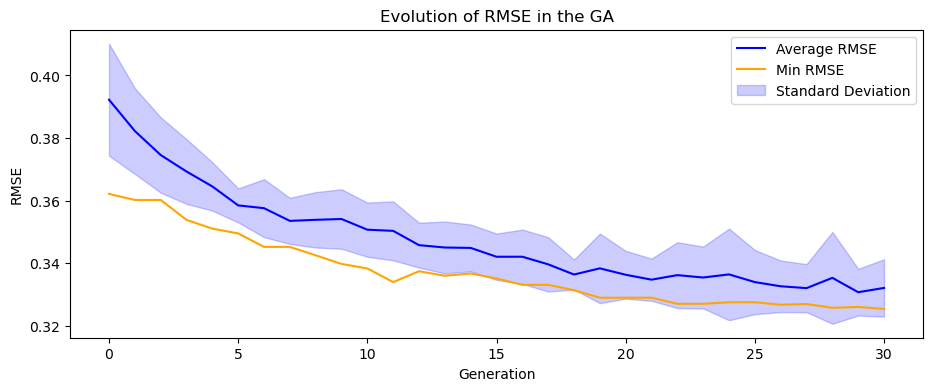

In [16]:
# Assuming logbook is already defined and populated
gen = np.array(logbook.select("gen"))
avg_mse = np.array(logbook.select("avg"))
min_mse = np.array(logbook.select("min"))
std_mse = np.array(logbook.select("std"))

# Calculate the upper and lower bounds for the shaded area
upper_bound = avg_mse + std_mse
lower_bound = avg_mse - std_mse

# Plot the graph
plt.figure(figsize=(11, 4))
plt.title("Evolution of RMSE in the GA")
plt.plot(gen, avg_mse, label="Average RMSE", color="blue")
plt.plot(gen, min_mse, label="Min RMSE", color="orange")
plt.fill_between(gen, lower_bound, upper_bound, color='blue', alpha=0.2, label="Standard Deviation")
plt.xlabel("Generation")
plt.ylabel("RMSE")
plt.legend()
plt.show()

In [17]:
display(hof.items)
# Assuming 'hof' is your HallOfFame object
best_individual = hof[0]  # The best individual
best_weights = {name: weight for name, weight in zip(weights.keys(), best_individual)}
best_mse = best_individual.fitness.values[0]

print("Best MSE:", best_mse)
print("Best Weights:")
for name, weight in best_weights.items():
    print(f"{name}: {weight}")

[[163.85385541347304,
  50.22955270367241,
  0.7763408177299956,
  163.37827338705705,
  33.529536354590775,
  6.014113558513104,
  219.13331788159817,
  0.9716146911647117,
  0.36281282650985114,
  202.44326553763074,
  22.661898399170035,
  2.0081849756997054,
  41.74197415863212,
  52.19871648583238,
  58.861586266528576,
  88.69583325654665,
  6.634250710648821,
  89.28285577188296,
  101.63189788739884,
  32.07111790546567,
  51.30571670651456,
  85.70437433460862,
  0,
  0]]

Best MSE: 0.3253718381361683
Best Weights:
traffic_weight: 163.85385541347304
apartments_weight: 50.22955270367241
cinemas_weight: 0.7763408177299956
clinics_weight: 163.37827338705705
colleges_weight: 33.529536354590775
communityCentres_weight: 6.014113558513104
conferenceCentres_weight: 219.13331788159817
dentists_weight: 0.9716146911647117
eventsVenues_weight: 0.36281282650985114
fastFoods_weight: 202.44326553763074
hospitals_weight: 22.661898399170035
hotels_weight: 2.0081849756997054
leisureFitnessCentres_weight: 41.74197415863212
leisureStadiums_weight: 52.19871648583238
placesOfWorship_weight: 58.861586266528576
restaurants_weight: 88.69583325654665
shopMalls_weight: 6.634250710648821
shopSupermarkets_weight: 89.28285577188296
sportsCentres_weight: 101.63189788739884
sportsHalls_weight: 32.07111790546567
stadiums_weight: 51.30571670651456
substationMinorDistributions_weight: 85.70437433460862
theatres_weight: 0
universities_weight: 0


In [18]:
with open("weights_float.txt", "w") as file:
    for name, value in best_weights.items():
        file.write(f"{name} {float(value)}\n")

In [19]:
# Define the path to the compiled executable
executable_path = './gravityscore'

# The CSV file name to pass as an argument
csv_file_name = 'citty.csv'

# Run the compiled C++ program with the CSV file name as an argument
result = subprocess.run([executable_path, csv_file_name], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

# Process the result
if result.returncode == 0:
    print("C++ program output:\n", result.stdout)
else:
    print("Error running C++ program:\n", result.stderr)

C++ program output:
 Time taken: 8563 milliseconds



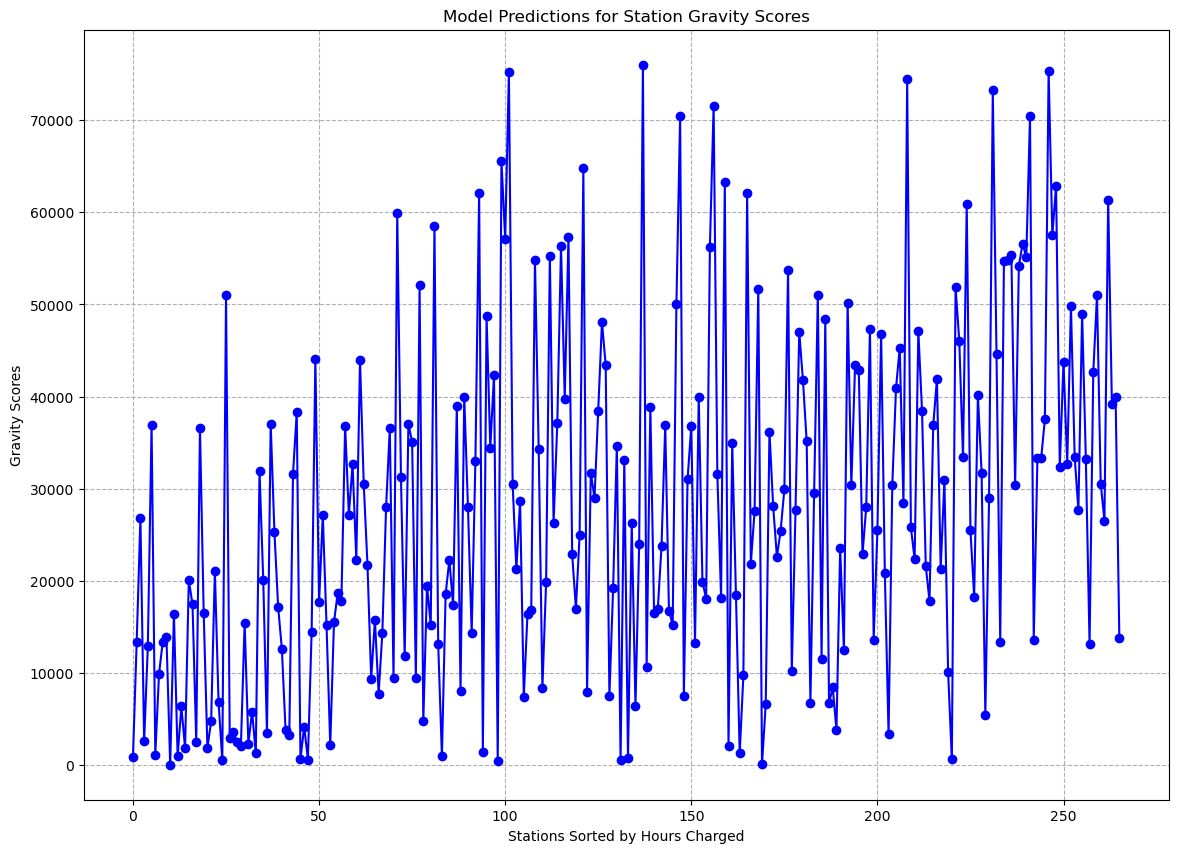

In [20]:
df_gravity = pd.read_csv('gravityScoresWithDetails.csv')
#change all gravity that a negative to zero
df_gravity['gravity'] = df_gravity['gravity'].apply(lambda x: 0 if x < 0 else x)

#plot df_gravity where x asis the the index and y axis the gravity
plt.figure(figsize=(14, 10))
plt.plot(df_gravity.index, df_gravity['gravity'], marker='o', linestyle='-', color='blue')
plt.xlabel('Stations Sorted by Hours Charged')
plt.ylabel('Gravity Scores')
plt.title('Model Predictions for Station Gravity Scores')
plt.grid(True, which="both", ls="--")
plt.show()

Mean Squared Error (MSE) on scaled data: 0.1277254067791431
Root Mean Squared Error (RMSE) on scaled data: 0.35738691467252


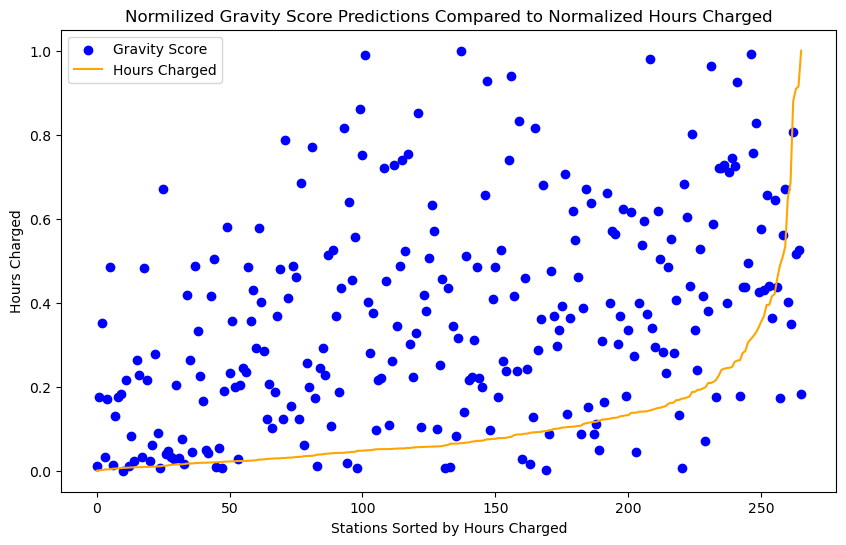

Mean Squared Error (MSE) on scaled data: 0.10586683305210894
Root Mean Squared Error (RMSE) on scaled data: 0.3253718381361683


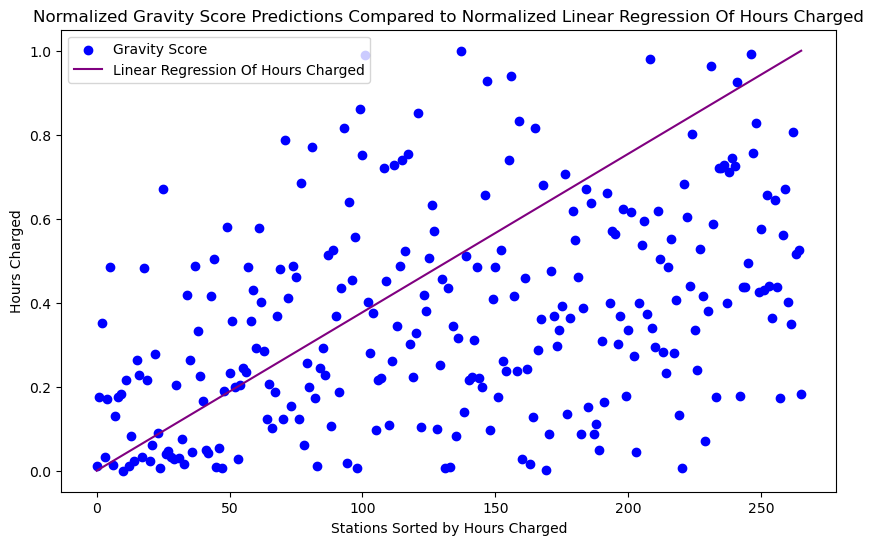

In [21]:
X = np.arange(len(df_citty)).reshape(-1, 1)  # Element numbers as X
y = df_gravity['gravity'].values.reshape(-1, 1)
#y = df_reordered_sorted['status_3_ratio_mean'].values.reshape(-1, 1)  # status_3_ratio_mean as Y, reshaped for scaler


scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_gravity_scaled = scaler_y.fit_transform(y)


# Calculate MSE on the scaled predictions
mse_scaled = mean_squared_error(y_gravity_scaled, y_scaled)
rmse = np.sqrt(mse_scaled)

mse = mean_squared_error(y, y_original)

print(f"Mean Squared Error (MSE) on scaled data: {mse_scaled}")
print(f"Root Mean Squared Error (RMSE) on scaled data: {rmse}")


# Plotting the results (optional)
plt.figure(figsize=(10, 6))
plt.scatter(X, y_gravity_scaled, color='blue', label='Gravity Score')
plt.plot(X, y_scaled, color='orange', label='Hours Charged')
plt.title('Normilized Gravity Score Predictions Compared to Normalized Hours Charged')
plt.xlabel('Stations Sorted by Hours Charged')
plt.ylabel('Hours Charged')
plt.legend()
plt.show()


# Calculate MSE on the scaled predictions
mse_scaled = mean_squared_error(y_gravity_scaled, y_scaled_lin)
rmse = np.sqrt(mse_scaled)

# If you want to calculate MSE on the original scale
mse = mean_squared_error(y, y_original)

print(f"Mean Squared Error (MSE) on scaled data: {mse_scaled}")
print(f"Root Mean Squared Error (RMSE) on scaled data: {rmse}")

# Plotting the results (optional)
plt.figure(figsize=(10, 6))
plt.scatter(X, y_gravity_scaled, color='blue', label='Gravity Score')
plt.plot(X, y_scaled_lin, color='purple', label='Linear Regression Of Hours Charged')
plt.title('Normalized Gravity Score Predictions Compared to Normalized Linear Regression Of Hours Charged')
plt.xlabel('Stations Sorted by Hours Charged')
plt.ylabel('Hours Charged')
plt.legend()
plt.show()

C++ program output:
 Time taken: 5846 milliseconds



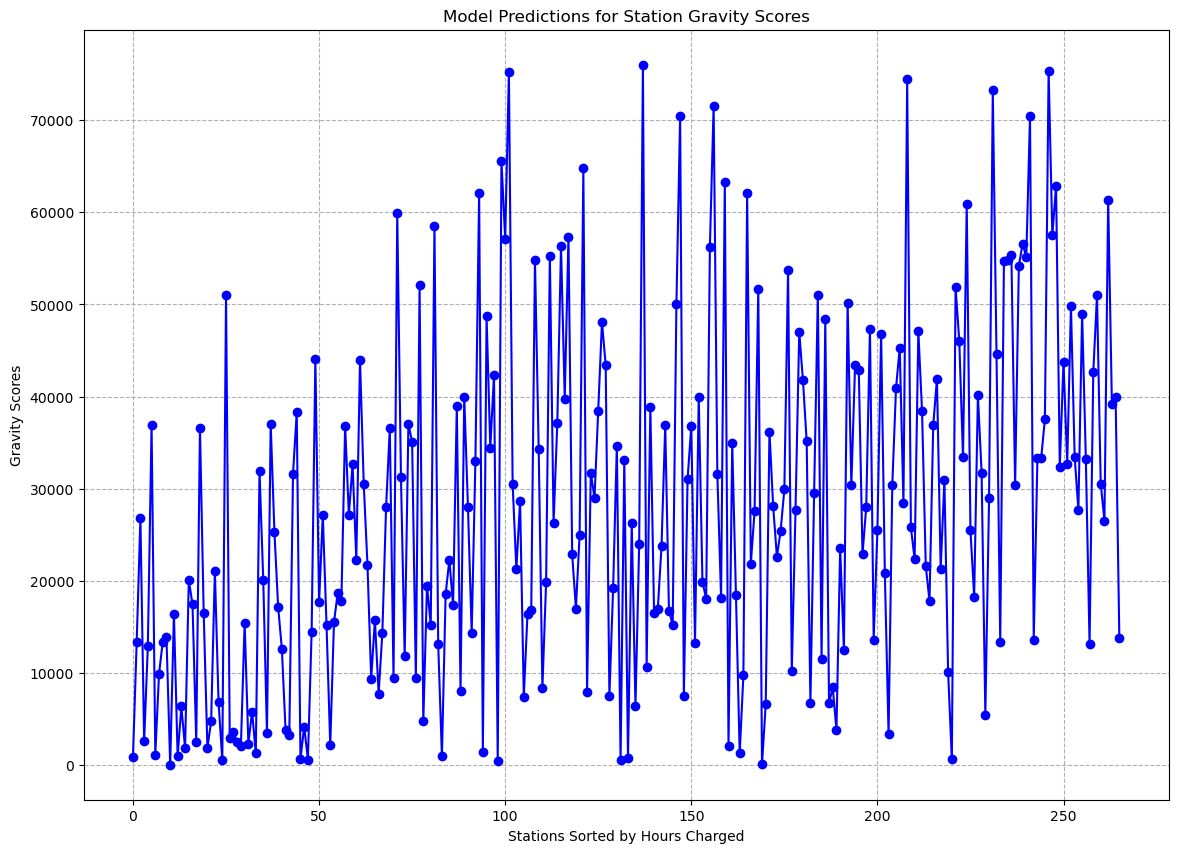

Mean Squared Error (MSE) on scaled data: 0.1277254067791431
Root Mean Squared Error (RMSE) on scaled data: 0.35738691467252


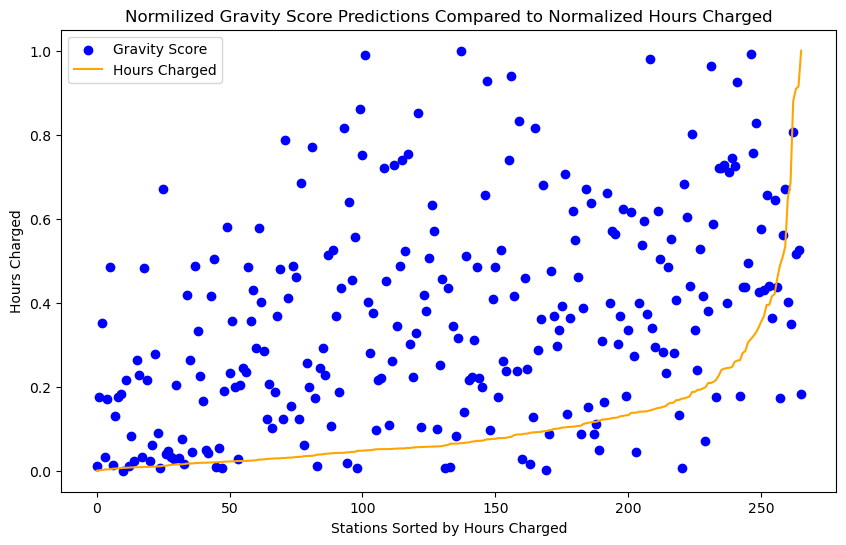

Mean Squared Error (MSE) on scaled data: 0.10586683305210894
Root Mean Squared Error (RMSE) on scaled data: 0.3253718381361683


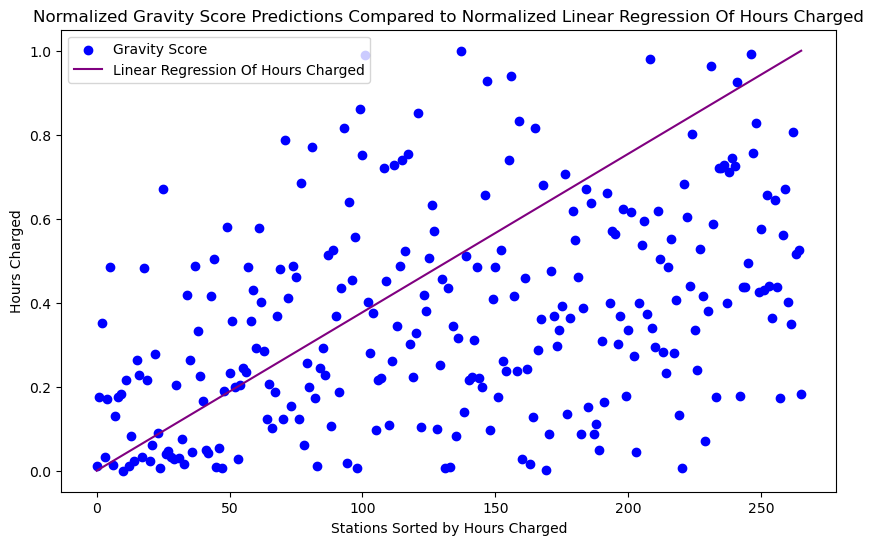

In [31]:
weights = {
"traffic_weight": 163.85385541347304,
"apartments_weight": 50.22955270367241,
"cinemas_weight": 0.7763408177299956,
"clinics_weight": 163.37827338705705,
"colleges_weight": 33.529536354590775,
"communityCentres_weight": 6.014113558513104,
"conferenceCentres_weight": 219.13331788159817,
"dentists_weight": 0.9716146911647117,
"eventsVenues_weight": 0.36281282650985114,
"fastFoods_weight": 202.44326553763074,
"hospitals_weight": 22.661898399170035,
"hotels_weight": 2.0081849756997054,
"leisureFitnessCentres_weight": 41.74197415863212,
"leisureStadiums_weight": 52.19871648583238,
"placesOfWorship_weight": 58.861586266528576,
"restaurants_weight": 88.69583325654665,
"shopMalls_weight": 6.634250710648821,
"shopSupermarkets_weight": 89.28285577188296,
"sportsCentres_weight": 101.63189788739884,
"sportsHalls_weight": 32.07111790546567,
"stadiums_weight": 51.30571670651456,
"substationMinorDistributions_weight": 85.70437433460862,
"theatres_weight": 0,
"universities_weight": 0,

}
with open("weights_float.txt", "w") as file:
    for name, value in weights.items():
        file.write(f"{name} {float(value)}\n")


# Define the path to the compiled executable
executable_path = './gravityscore'

# The CSV file name to pass as an argument
csv_file_name = 'citty.csv'

# Run the compiled C++ program with the CSV file name as an argument
result = subprocess.run([executable_path, csv_file_name], stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)

# Process the result
if result.returncode == 0:
    print("C++ program output:\n", result.stdout)
else:
    print("Error running C++ program:\n", result.stderr)

df_gravity = pd.read_csv('gravityScoresWithDetails.csv')
#change all gravity that a negative to zero
df_gravity['gravity'] = df_gravity['gravity'].apply(lambda x: 0 if x < 0 else x)

#plot df_gravity where x asis the the index and y axis the gravity
plt.figure(figsize=(14, 10))
plt.plot(df_gravity.index, df_gravity['gravity'], marker='o', linestyle='-', color='blue')
plt.xlabel('Stations Sorted by Hours Charged')
plt.ylabel('Gravity Scores')
plt.title('Model Predictions for Station Gravity Scores')
plt.grid(True, which="both", ls="--")
plt.show()

X = np.arange(len(df_citty)).reshape(-1, 1)  # Element numbers as X
y = df_gravity['gravity'].values.reshape(-1, 1)
#y = df_reordered_sorted['status_3_ratio_mean'].values.reshape(-1, 1)  # status_3_ratio_mean as Y, reshaped for scaler


scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_gravity_scaled = scaler_y.fit_transform(y)


# Calculate MSE on the scaled predictions
mse_scaled = mean_squared_error(y_gravity_scaled, y_scaled)
rmse = np.sqrt(mse_scaled)

mse = mean_squared_error(y, y_original)

print(f"Mean Squared Error (MSE) on scaled data: {mse_scaled}")
print(f"Root Mean Squared Error (RMSE) on scaled data: {rmse}")


# Plotting the results (optional)
plt.figure(figsize=(10, 6))
plt.scatter(X, y_gravity_scaled, color='blue', label='Gravity Score')
plt.plot(X, y_scaled, color='orange', label='Hours Charged')
plt.title('Normilized Gravity Score Predictions Compared to Normalized Hours Charged')
plt.xlabel('Stations Sorted by Hours Charged')
plt.ylabel('Hours Charged')
plt.legend()
plt.show()


# Calculate MSE on the scaled predictions
mse_scaled = mean_squared_error(y_gravity_scaled, y_scaled_lin)
rmse = np.sqrt(mse_scaled)

# If you want to calculate MSE on the original scale
mse = mean_squared_error(y, y_original)

print(f"Mean Squared Error (MSE) on scaled data: {mse_scaled}")
print(f"Root Mean Squared Error (RMSE) on scaled data: {rmse}")

# Plotting the results (optional)
plt.figure(figsize=(10, 6))
plt.scatter(X, y_gravity_scaled, color='blue', label='Gravity Score')
plt.plot(X, y_scaled_lin, color='purple', label='Linear Regression Of Hours Charged')
plt.title('Normalized Gravity Score Predictions Compared to Normalized Linear Regression Of Hours Charged')
plt.xlabel('Stations Sorted by Hours Charged')
plt.ylabel('Hours Charged')
plt.legend()
plt.show()


In [32]:
weights_all_names= {
    "traffic_weight": 163.85385541347304,
    "apartments_weight": 50.22955270367241,
    "cinemas_weight": 0.7763408177299956,
    "clinics_weight": 163.37827338705705,
    "colleges_weight": 33.529536354590775,
    "communityCentres_weight": 6.014113558513104,
    "conferenceCentres_weight": 219.13331788159817,
    "dentists_weight": 0.9716146911647117,
    "eventsVenues_weight": 0.36281282650985114,
    "fastFoods_weight": 202.44326553763074,
    "hospitals_weight": 22.661898399170035,
    "hotels_weight": 2.0081849756997054,
    "leisureFitnessCentres_weight": 41.74197415863212,
    "leisureStadiums_weight": 52.19871648583238,
    "placesOfWorship_weight": 58.861586266528576,
    "restaurants_weight": 88.69583325654665,
    "shopMalls_weight": 6.634250710648821,
    "shopSupermarkets_weight": 89.28285577188296,
    "sportsCentres_weight": 101.63189788739884,
    "sportsHalls_weight": 32.07111790546567,
    "stadiums_weight": 51.30571670651456,
    "substationMinorDistributions_weight": 85.70437433460862,
    "theatres_weight": 0,
    "universities_weight": 0,

}

df_gravity = pd.read_csv('gravityScoresWithDetails.csv')
#change all gravity that a negative to zero
df_gravity['gravity'] = df_gravity['gravity'].apply(lambda x: 0 if x < 0 else x)

# Extracting names and removing '_weight' suffix
new_names = [name.replace('_weight', '') for name in weights_all_names.keys()]

# Generating new column names for df_gravity
# This includes keeping the original names for columns not being replaced
new_column_names = df_gravity.columns[:3].tolist() + new_names[:len(df_gravity.columns) - 3]

# Renaming the columns in df_gravity
df_gravity.columns = new_column_names

display(df_gravity)
#display the sum of each column
display(df_gravity.sum())


# Reset the index without changing the order of data
df_citty.reset_index(drop=True, inplace=True)

display(df_citty[['latitude', 'longitude','ratios_length', 'minCapacity', 'maxCapacity']])
df_gravity.to_csv('gravityScoresWithDetails.csv')

#add the collums ratios_length,minCapacity,maxCapacity from df_cittyway to df_gravity on the same index
df_gravity['ratios_length'] = df_citty['ratios_length']
df_gravity['minCapacity'] = df_citty['minCapacity']
df_gravity['maxCapacity'] = df_citty['maxCapacity']
df_gravity['slug'] = df_citty['slug']
df_gravity['use'] = df_citty['status_3_ratio_mean']
df_gravity['kommune'] = df_citty['NAME_2']

#make use only have two numbers after the point
df_gravity['use'] = df_gravity['use'].apply(lambda x: round(x, 2))

display(df_gravity[['latitude', 'longitude', 'gravity', 'use', 'ratios_length', 'minCapacity', 'maxCapacity', 'kommune', 'slug']])
df_gravity.to_csv('cittyTest.csv')

,longitude,latitude,gravity,traffic,apartments,cinemas,clinics,colleges,communityCentres,conferenceCentres,...,placesOfWorship,restaurants,shopMalls,shopSupermarkets,sportsCentres,sportsHalls,stadiums,substationMinorDistributions,theatres,universities
0,8.83612,56.7820,851.252,0.0000,0.000,0.0000,0.000,0.0000,0.00000,0.0,...,300.770,0.00,0.000,180.225,0.0,0.000,0.0,0.00,0,0
1,10.18240,57.0617,13377.800,0.0000,0.000,0.0000,0.000,0.0000,0.00000,0.0,...,0.000,0.00,0.000,13377.800,0.0,0.000,0.0,0.00,0,0
2,9.12968,55.1301,26765.500,22.2776,0.000,0.0000,0.000,0.0000,0.00000,0.0,...,346.131,13155.00,0.000,13242.100,0.0,0.000,0.0,0.00,0,0
3,11.34300,55.4140,2577.200,0.0000,159.430,0.0000,0.000,74.2319,0.00000,0.0,...,0.000,1236.05,0.000,913.374,0.0,0.000,0.0,0.00,0,0
4,9.91177,56.3591,12957.300,38.9530,0.000,0.0000,0.000,0.0000,49.56530,0.0,...,326.201,11958.70,0.000,583.895,0.0,0.000,0.0,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,10.06180,56.4303,26519.800,63.6402,252.704,0.0000,1660.360,108.5640,0.00000,0.0,...,400.370,16775.70,276.856,1485.980,0.0,0.000,0.0,0.00,0,0
262,12.50480,55.7727,61371.100,0.0000,3770.870,19.5588,474.078,0.0000,184.49300,0.0,...,9403.750,9880.64,937.863,14936.700,0.0,144.956,0.0,12054.10,0,0
263,10.42670,55.3865,39218.000,21.5511,966.539,23.5823,0.000,0.0000,36.77870,0.0,...,0.000,11429.00,109.676,3185.060,0.0,0.000,0.0,0.00,0,0
264,10.06330,56.4296,39929.300,68.7279,375.132,0.0000,988.020,150.2420,0.00000,0.0,...,477.085,24336.60,632.945,2371.360,0.0,0.000,0.0,0.00,0,0


longitude                       2.869529e+03
latitude                        1.486083e+04
gravity                         7.380786e+06
traffic                         3.440090e+04
apartments                      1.165166e+06
cinemas                         1.709437e+03
clinics                         2.669939e+05
colleges                        3.224186e+04
communityCentres                1.569122e+04
conferenceCentres               5.700801e+04
dentists                        2.207650e+03
eventsVenues                    6.464785e+02
fastFoods                       7.464005e+05
hospitals                       2.616747e+04
hotels                          2.638164e+03
leisureFitnessCentres           2.185716e+05
leisureStadiums                 1.542738e+04
placesOfWorship                 2.946423e+05
restaurants                     1.381893e+06
shopMalls                       1.933520e+04
shopSupermarkets                2.114362e+06
sportsCentres                   4.256879e+04
sportsHall

,latitude,longitude,ratios_length,minCapacity,maxCapacity
0,56.781975,8.836123,1,50.0,50.0
1,57.061677,10.182387,2,90.0,90.0
2,55.130120,9.129680,2,43.0,50.0
3,55.414030,11.342991,4,50.0,60.0
4,56.359149,9.911765,2,150.0,150.0
...,...,...,...,...,...
261,56.430273,10.061784,16,250.0,250.0
262,55.772665,12.504799,12,250.0,250.0
263,55.386511,10.426722,15,250.0,250.0
264,56.429629,10.063318,44,22.0,300.0


,latitude,longitude,gravity,use,ratios_length,minCapacity,maxCapacity,kommune,slug
0,56.7820,8.83612,851.252,0.16,1,50.0,50.0,Morsø,7nyr93
1,57.0617,10.18240,13377.800,0.26,2,90.0,90.0,Aalborg,5np96k
2,55.1301,9.12968,26765.500,0.37,2,43.0,50.0,Tønder,pz5kg3
3,55.4140,11.34300,2577.200,0.44,4,50.0,60.0,Slagelse,39xd56
4,56.3591,9.91177,12957.300,0.49,2,150.0,150.0,Favrskov,7ky5yz
...,...,...,...,...,...,...,...,...,...
261,56.4303,10.06180,26519.800,70.82,16,250.0,250.0,Randers,njjg6y
262,55.7727,12.50480,61371.100,90.90,12,250.0,250.0,Lyngby-Taarbæk,rggmqx
263,55.3865,10.42670,39218.000,93.89,15,250.0,250.0,Odense,kjdxe9
264,56.4296,10.06330,39929.300,94.53,44,22.0,300.0,Randers,6k7qmg


In [30]:
#in df_gravity count how many values in each column are non zero
non_zero_counts = df_gravity.astype(bool).sum()
display(non_zero_counts)

longitude                       266
latitude                        266
gravity                         266
traffic                         158
apartments                      214
cinemas                          96
clinics                          81
colleges                         60
communityCentres                128
conferenceCentres                11
dentists                         80
eventsVenues                    103
fastFoods                       109
hospitals                        57
hotels                           36
leisureFitnessCentres           157
leisureStadiums                  34
placesOfWorship                 211
restaurants                     213
shopMalls                        79
shopSupermarkets                253
sportsCentres                    30
sportsHalls                      35
stadiums                          4
substationMinorDistributions     98
theatres                          0
universities                      0
ratios_length               